In [1]:
import os
import pandas as pd
import time
from bs4 import BeautifulSoup
import undetected_chromedriver as uc

In [2]:
url = 'https://market.yandex.ru/shop--zolotoe-iabloko/592587/reviews'

In [3]:
def captcha(func):
    
    def parse():
        page = driver.page_source
        soup = BeautifulSoup(page, 'lxml')
        return soup
    
    def wrapper(url):
        driver.get(url)
        soup = parse()
        print('Страница загружена')
                
        if soup.select_one('.utilityfocus'):
            print('Обнаружена капча')
            while soup.select_one('.utilityfocus'):
                print('Необходимо решить капчу')
                soup = parse()
                time.sleep(2)
                
        time.sleep(2)
        soup = parse()
        
        return func(soup)
    return wrapper

In [33]:
@captcha
def test_f(soup):
    time.sleep(2)
    df = pd.DataFrame(columns=['username', 'score', 'delivery', 'date', 'positive', 'negative', 'comment', 'answer', 'likes', 'dislikes'])
    
    for review in soup.select('._1T0L5'):
        row = []
        try:
            row.append(review.find('div', {'data-auto': 'user_name'}).text)  # Name
        except:
            row.append(None)
        try:
            row.append(review.find('div', {'class': 'JOpBg'}).text)  # Score
        except:
            row.append(None)
        try:
            row.append(review.select_one('._36v_m').text)  # Delivery
        except:
            row.append(None)
        try:
            row.append(review.select_one('span._1o1sC._3t21t').text)  # Date
        except:
            row.append(None)
        try:
            row.append(review.find('dl', {'data-auto': 'review-pro'}).find('dd').text)  # Positive
        except:
            row.append(None)
        try:
            row.append(review.find('dl', {'data-auto': 'review-contra'}).find('dd').text)  # Negetive
        except:
            row.append(None)
        try:
            row.append(review.find('dl', {'data-auto': 'review-comment'}).find('dd').text)  # Comment
        except:
            row.append(None)
        try:
            row.append(review.select('div[data-tid]')[-2].text)  # Answer
        except:
            row.append(None)
        try:
            row.append(review.select_one('div[data-auto=review-like] span[data-auto=buttonText] span[data-auto=count]').text)  # Likes
        except:
            row.append(None)
        try:
            row.append(review.select_one('div[data-auto=review-dislike] span[data-auto=buttonText] span[data-auto=count]').text)  # Dislikes
        except:
            row.append(None)
        df.loc[df.shape[0], :] = row
    return df 

In [34]:
def save(df):
    if os.path.exists('Yandex_reviews.xlsx'):
        df_ = pd.read_excel('Yandex_reviews.xlsx')
        df = pd.concat([df_, df])
        df.drop_duplicates(inplace=True)
    df.to_excel('Yandex_reviews.xlsx', index=False)    

In [ ]:
page = 1
driver = uc.Chrome()
while True:
    print('Страница ', page)
    if 'поставили магазину оценку, но ничего не' in driver.page_source:
        break
    df = test_f(url + f'?page={page}')
    save(df)
    page += 1
    time.sleep(10)

# Постобработка

In [36]:
from datetime import timedelta
from datetime import datetime

In [37]:
df = pd.read_excel('Yandex_reviews.xlsx')

In [38]:
df.head(5)

,username,score,delivery,date,positive,negative,comment,answer,likes,dislikes
0,Алёна К.,Отличный магазин,Способ покупки: доставка,"6 дней назад, Саратов","Всё пришло в срок, хорошо упакованное, без пов...",Не измельчает более твердые сорта фруктов и ов...,"Первый раз оформляла заказ в приложении ""Золот...","Добрый день, Алёна!\n\nБлагодарим, что поделил...",1,0
1,Имя скрыто,Отличный магазин,Способ покупки: доставка,"6 дней назад, Клин",KITFORT кт-1005-2\nЗолотое яблоко для меня ока...,NaN,NaN,"Добрый день!\n\nСпасибо, что делитесь своими в...",0,2
2,Алина Б.,Отличный магазин,Способ покупки: доставка,"Неделю назад, Москва",Быстрая доставка в тот же день.,Нет,"Заказывала масло от растяжек, которое нигде не...","Добрый день, Алина!\n\nБлагодарим вас за отзыв...",3,6
3,Vyacheslav Trushkov,Ужасный магазин,Способ покупки: доставка,"Неделю назад, Москва",NaN,Сделал заказ в приложении. Время доставки было...,NaN,"Добрый день!\n\nБлагодарим, что рассказали о п...",0,0
4,Имя скрыто,Ужасный магазин,NaN,"Неделю назад, Новосибирск",NaN,Был оформлен заказ 20 декабря с датой курьерск...,NaN,Добрый день!\n\nПриносим свои извинения за дли...,0,0


In [39]:
def parse_date(x):
    city = x.str.split(',').apply(lambda x: x[1] if len(x)>1 else None).str.strip()
    date = x.str.split(',').apply(lambda x: x[0])
    
    d_ = {
        'час': timedelta(hours=1),
        'вчера': timedelta(hours=24),
        'дн' : timedelta(hours=24),
        'позавчера': timedelta(days=2), 
        'нед': timedelta(weeks=1),
        'мес': timedelta(weeks=4),
        'год': timedelta(weeks=48)
    }
    count = date.str.findall(r'\d+').apply(lambda x: 1 if len(x)==0 else x[0]).astype(int)
    date_ = date.str.lower().str.findall(r'час|^вчера|дн|^позавчера|нед|мес|год').apply(lambda x: x[0])
    date = datetime.now() - date_.map(d_) * count
    return date, city

In [40]:
df['parse_score'] = df['score'].map({'Ужасный магазин': 1, 'Плохой магазин': 2, 'Обычный магазин': 3, 'Хороший магазин': 4, 'Отличный магазин': 5})

<AxesSubplot:>

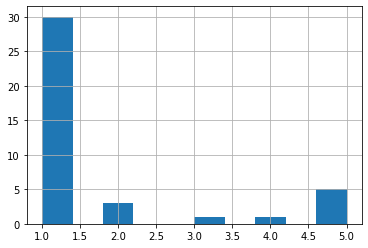

In [42]:
df['parse_score'].hist()